In [36]:
# install libraries
!pip install comet_ml
!pip install spacy
!pip install seaborn
!pip install wordcloud
!pip install emoji
!pip install pyspellchecker
!pip install ftfy

In [37]:
# download NLP package
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [38]:
# Import package for creating an experiment in Comet
import comet_ml
from comet_ml import Experiment


In [39]:
# Standard Packages  
import numpy as np
import pandas as pd
from time import time

# Packages for visualisations
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set(font_scale=1.5)
import matplotlib.style as style
style.use('seaborn-pastel')
style.use('seaborn-poster')
from PIL import Image

# Packages for preprocessing
import re
import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.probability import FreqDist
import emoji
from ftfy import fix_text
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet 
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import itertools
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Packages for training models
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC

# Packages for hyperparameter optimisation
from sklearn.model_selection import GridSearchCV

# Packages for evaluating model accuracy
from sklearn import metrics
from sklearn.metrics import f1_score 
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize

# Packages for saving models
import pickle

## COMET

In [40]:
# Setting the API key 
experiment = Experiment(api_key='uFXkuw4i4BqB5FxidwiS5nIHM',
                        project_name="Twitter", workspace="kennedyee")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kennedyee/twitter/fd59c9b12215490c8ce72417608bc507
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: To get all data logged automatical

In [41]:
# Import training dataset
df_train = pd.read_csv('train.csv')

# Import testing dataset
df_test = pd.read_csv('test.csv')
# Set 'tweetid' index
df_train.set_index('tweetid',inplace = True)
df_test.set_index('tweetid',inplace = True)

In [42]:
print(df_train.shape)
print(df_test.shape)

(15819, 2)
(10546, 1)


In [43]:
df_train.columns

Index(['sentiment', 'message'], dtype='object')

In [44]:
df_train.head()

,sentiment,message
tweetid,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...
126103,1,It's not like we lack evidence of anthropogeni...
698562,2,RT @RawStory: Researchers say we have three ye...
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


In [45]:
df_train['sentiment'].unique()

array([ 1,  2,  0, -1], dtype=int64)

## Class Description:
Class 2 News: the tweet links to factual news about climate change

Class1 Pro: the tweet supports the belief of man-made climate change

Class 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change.

Class-1 Anti: the tweet does not believe in man-made climate change Variable definitions

## Preprocessing
Extract tweet sentiments

Extract hashtags

Replace contractions

Remove URLS,punctuations,mentions, numbers and extra white space, unicode

Replace emojis

Convert all text to lowercase

Replace shortened words/slang

Tokenization

Perform lemmatization

In [46]:
def update(df):

    df = df_train.copy()
    sentiment = df['sentiment']
    word_sentiment = []

    for i in sentiment :
        if i == 1 :
            word_sentiment.append('Pro')
        elif i == 0 :
            word_sentiment.append('Neutral')
        elif i == -1 :
            word_sentiment.append('Anti')
        else :
            word_sentiment.append('News')

    df['sentiment'] = word_sentiment
    
    return df

df = update(df_train)
df.head()

,sentiment,message
tweetid,,
625221,Pro,PolySciMajor EPA chief doesn't think carbon di...
126103,Pro,It's not like we lack evidence of anthropogeni...
698562,News,RT @RawStory: Researchers say we have three ye...
573736,Pro,#TodayinMaker# WIRED : 2016 was a pivotal year...
466954,Pro,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


## Extracting Hashtags
Extracting hashtags for original tweets and storing them in seperate dataframes for each class before first cleaning the data.

In [47]:
def hashtag_extract(tweet):
    
    hashtags = []
    
    for i in tweet:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
        
    hashtags = sum(hashtags, [])
    frequency = nltk.FreqDist(hashtags)
    
    hashtag_df = pd.DataFrame({'hashtag': list(frequency.keys()),
                       'count': list(frequency.values())})
    hashtag_df = hashtag_df.nlargest(15, columns="count")

    return hashtag_df

# Extracting the hashtags from tweets in each class
pro = hashtag_extract(df['message'][df['sentiment'] == 'Pro'])
anti = hashtag_extract(df['message'][df['sentiment'] == 'Anti'])
neutral = hashtag_extract(df['message'][df['sentiment'] == 'Neutral'])
news = hashtag_extract(df['message'][df['sentiment'] == 'News'])

pro.head()

,hashtag,count
19,climate,187
24,BeforeTheFlood,129
68,climatechange,94
13,ImVotingBecause,62
4,COP22,59


## Extracting Sentiments of Tweets
classifying all tweets with scores of less than -0.05 as negative, scores between -0.05 and 0.05 are classified as neutral and a score of more than 0.05 indicates a positive tweet.

In [48]:
def sentiment_score(text):
    
    sid = SentimentIntensityAnalyzer()
    s = sid.polarity_scores(text)['compound']
    if s<-0.05:
        sentiment='negative'
    elif s>0.05:
        sentiment='positive'
    else:
        sentiment='neutral'
    
    return sentiment

In [49]:
# Extract all unique news related handles into a list
df_temp = df_train.copy()
df_temp.sort_index(inplace=True)
n_temp = [re.findall(r'@[\w]+',df_temp['message'].iloc[i]) for i,x in enumerate(df_temp['sentiment']) if x==2]
news = [x for x in n_temp if x!=[]]

# Only keep the unique values inside the list
news = sorted(list(set(itertools.chain.from_iterable(news))))

In [50]:
# extracting all unque hashtags
hashtags = df['message'].apply(lambda x: re.findall(r'[#]\\w+',x))

In [51]:
hashtags = list(set([item for sublist in hashtags for item in sublist]))

In the next steps, we will be removing URL's, punctuations, mentions, numbers, extra white spaces and normalizing by converting all letters to lowercase



In [52]:
# Dictionary of contracted words
contractions = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"wasn't": "was not",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we'll":"we will",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
}

In [53]:
# Replace contracted words with full words
df_train['message'] = [' '.join([contractions[w.lower()] if w.lower() in contractions.keys() else w for w in raw.split()]) 
                       for raw in df_train['message']]


In [54]:
# Lower case all words to remove noise from Capital words. Capital words may be seen as different from lower case words
df_train['message'] = df_train['message'].str.lower()

In [55]:
# Fix all the bad unicode to allow better processing of the data
df_train['message'] = df_train['message'].apply(lambda x: fix_text(x))


In [56]:
# Remove vurls with urls
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'https\S+','url',x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'www\S+', 'url',x))
# Replace emojis with their word meaning
df_train['message'] = df_train['message'].apply(lambda x: emoji.demojize(x))

In [57]:
df_train.head()

,sentiment,message
tweetid,,
625221,1,polyscimajor epa chief does not think carbon d...
126103,1,it is not like we lack evidence of anthropogen...
698562,2,rt @rawstory: researchers say we have three ye...
573736,1,#todayinmaker# wired : 2016 was a pivotal year...
466954,1,"rt @soynoviodetodas: it is 2016, and a racist,..."


In [58]:
# Replace shortened words with full words
short = {' BD ': ' Big Deal ',
 ' abt ':' about ',
 ' ab ': ' about ',
 ' fav ': ' favourite ',
 ' fab ': ' fabulous ',
 ' smh ': ' shaking my head ',
 ' u ': ' you ',
 ' c ': ' see ',
 ' anon ': ' anonymous ',
 ' ac ': ' aircon ',
 ' a/c ': ' aircon ',
 ' yo ':' year old ',
 ' n ':' and ',
 ' nd ':' and ',
 ' 2 ': ' to ',
 ' w ': ' with ',
 ' w/o ': ' without ',
 ' r ': ' are ',
 ' rip ':' rest in peace ',
 ' 4 ' : ' for ',
' BF ': ' Boyfriend ',
' BRB ': ' Be Right Back ',
' BTW ': ' By The Way ',
' GF ': ' Girlfriend ',
' HBD ': ' Happy Birthday ',
' JK ': ' Just Kidding ',
' K ':' Okay ',
' LMK ': ' Let Me Know ',
' LOL ': ' Laugh Out Loud ',
' HA ':' laugh ',
' MYOB ': ' Mind Your Own Business ',
' NBD ': ' No Big Deal ',
' NVM ': ' Nevermind ',
' Obv ':' Obviously ',
' Obvi ':' Obviously ',
' OMG ': ' Oh My God ',
' Pls ': ' Please ',
' Plz ': ' Please ',
' Q ': ' Question ', 
' QQ ': ' Quick Question ',
' RLY ': ' Really ',
' SRLSY ': ' Seriously ',
' TMI ': ' Too Much Information ',
' TY ': ' Thank You, ',
' TYVM ': ' Thank You Very Much ',
' YW ': ' You are Welcome ',
' FOMO ': ' Fear Of Missing Out ',
' FTFY ': ' Fixed This For You ',
' FTW ': ' For The Win ',
' FYA ': ' For Your Amusement ',
' FYE ': ' For Your Entertainment ',
' GTI ': ' Going Through It ',
' HTH ': ' Here to Help ',
' IRL ': ' In Real Life ',
' ICYMI ': ' In Case You Missed It ',
' ICYWW ': ' In Case You Were Wondering ',
' NBC ': ' Nobody Cares Though ',
' NTW ': ' Not To Worry ',
' OTD ': ' Of The Day ',
' OOTD ': ' Outfit Of The Day ',
' QOTD ': ' Quote of the Day ',
' FOTD ': ' Find Of the Day ',
' POIDH ': ' Pictures Or It Did ntt Happen ',
' YOLO ': ' You Only Live Once ',
' AFAIK ': ' As Far As I Know ',
' DGYF ': ' Dang Girl You Fine ',
' FWIW ': ' For What It is Worth ',
' IDC ': ' I Do not Care ',
' IDK ': ' I Do not Know ',
' IIRC ': ' If I Remember Correctly ',
' IMHO ': ' In My Honest Opinion ',
' IMO ': ' In My Opinion ',
' Jelly ': ' Jealous ',
' Jellz ': ' Jealous ',
' JSYK ': ' Just So You Know ',
' LMAO ': ' Laughing My Ass Off ',
' LMFAO ': ' Laughing My Fucking Ass Off ',
' NTS ': ' Note to Self ',
' ROFL ': ' Rolling On the Floor Laughing ',
' ROFLMAO ': ' Rolling On the Floor Laughing My Ass Off ',
' SMH ': ' Shaking My Head ',
' TBH ': ' To Be Honest ',
' TL;DR ':  ' Too Long; Did not Read ',
' TLDR ':  ' Too Long; Did not Read ',
' YGTR ': ' You Got That Right ',
' AYKMWTS ': ' Are You Kidding Me With This Shit ',
' BAMF ': ' Bad Ass Mother Fucker ',
' FFS ': ' For Fuck Sake ',
' FML ': ' Fuck My Life ',
' HYFR ': ' Hell Yeah Fucking Right ',
' IDGAF ': ' I Do not Give A Fuck ',
' NFW ': ' No Fucking Way ',
' PITA ': ' Pain In The Ass ',
' POS ': ' Piece of Shit ',
' SOL ': ' Shit Outta Luck ',
' STFU ': ' Shut the Fuck Up ',
' TF ': ' The Fuck ',
' WTF ': ' What The Fuck ',
' BFN ': ' Bye For Now ',
' CU ': ' See You ',
' IC ': ' I see ',
' CYL ': ' See You Later ',
' GTG ': ' Got to Go ',
' OMW ': ' On My Way ',
' RN ': ' Right Now ',
' TTYL ': ' Talk To You Later ',
' TYT ': ' Take Your time ',
' CC ': ' Carbon Copy ',
' CX ': ' Correction ',
' DM ': ' Direct Message ',
' FB ': ' Facebook ',
' FBF ': ' Flash-Back Friday ',
' FF ': ' Follow Friday ',
' HT ': ' Tipping my hat ',
' H/T ': ' Tipping my hat ',
' IG ': ' Instagram ',
' Insta ': ' Instagram ',
' MT ':' Modified Tweet ',
' OH ': ' Overheard ',
' PRT ': ' Partial Retweet ',
' RT ': ' Retweet ',
'rt ' : ' retweet ',
' SO ':' Shout Out ',
' S/O ': ' Shout Out ',
' TBT ': ' Throw-Back Thursday ',
' AWOL ': ' Away While Online ',
' BFF ': ' Best Friend Forever ',
' NSFW ': ' Not Safe For Work ',
' OG ': ' Original Gangster ',
' PSA ': ' Public Service Announcement ',
' PDA ': ' Public Display of Affection '}

short = dict((key.lower(), value.lower()) for key,value in short.items())

In [59]:
# Replacing shortened words with full alternative words
for word in short.keys():
    df_train['message'] = df_train['message'].apply(lambda x: re.sub(word,short[word],x))

In [60]:
# Remove twitter non news related handles and @ symbol
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'@', '', ' '.join([y for y in x.split() if y not in 
                                                                                     [z for z in re.findall(r'@[\w]*',x) 
                                                                                      if z not in news]])))

In [61]:
# Add sentiment
df_train['message'] = df_train['message'].apply(lambda x: x + ' ' + sentiment_score(x)) 

In [62]:
# Remove punctuations
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r"[^A-Za-z ]*",'',x))

In [63]:
# Remove repeated vowels 
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r'([aeiou])\1+', r'\1\1', x))

In [64]:
# Replace slang words
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r' ha([ha]) *', r'laugh', x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r' he([he]) *', r'laugh', x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r' lol([ol]) *', r'laugh', x))
df_train['message'] = df_train['message'].apply(lambda x: re.sub(r' lo([o])*l ', r'laugh', x))

## Cleaning data

For all the prepocessing done above, here is the function to do all of that

In [65]:
def clean(raw):
    
    # Convert to lowercase
    raw = raw.lower()
    
    # Fix strange characters
    raw = fix_text(raw)
    
    # Removing urls
    raw = re.sub(r'https\S+','url',raw)
    raw = re.sub(r'www\S+', 'url',raw)
    
    # Replace emojis with their word meaning
    raw = emoji.demojize(raw)

    # Remove twitter non news related handles
    raw = ' '.join([y for y in raw.split() if y not in [x for x in re.findall(r'@[\w]*',raw) if x not in news]])
    
    # Add sentiment
    raw = raw + ' ' + sentiment_score(raw)
    
    # Remove punctuation
    raw = re.sub(r"[^A-Za-z ]*",'',raw)
    
    # Remove repeated vowels 
    raw = re.sub(r'([aeiou])\1+', r'\1\1', raw)
    
    # Replace slang words'
    raw = re.sub(r' ha([ha]) *', r'laugh', raw)
    raw = re.sub(r' he([he]) *', r'laugh', raw)
    raw = re.sub(r' lol([ol]) *', r'laugh', raw)
    raw = re.sub(r' lo([o])*l ', r'laugh', raw)
    
    return raw

In [66]:
# Replace contracted words with full word
df_test['message'] = [' '.join([contractions[w.lower()] if w.lower() in contractions.keys() else w for w in raw.split()]) 
                      for raw in df_test['message']]

In [67]:
# Replacing shortened words with full words
for word in short.keys():
    df_test['message'] = df_test['message'].apply(lambda x: re.sub(word,short[word],x))

In [68]:
# Apply cleaning function
df_test['message'] = df_test['message'].apply(lambda x: clean(x))

In [69]:
#Checking percentage of misspelled words in the data.
spell = SpellChecker() 
# check for misspelled words
misspelled = df_train['message'].apply(lambda x: spell.unknown(x))
print(misspelled.isnull().mean())

0.0


## Lemmatization

In [70]:
def lemma(df):
    
    """
    This function modifies the original train dataframe.
    A new column for the length of each tweet is added.
    The tweets are then tokenized and each word is assigned a part of speech tag 
    before being lemmatized
    
    Input:
    df: original dataframe
        datatype: dataframe 
        
    Output:
    df: modified dataframe
        datatype: dataframe
    """
    
    df['length'] = df['message'].str.len()
    df['tokenized'] = df['message'].apply(word_tokenize)
    df['pos_tags'] = df['tokenized'].apply(nltk.tag.pos_tag)

    def get_wordnet_pos(tag):

        if tag.startswith('J'):
            return wordnet.ADJ

        elif tag.startswith('V'):
            return wordnet.VERB

        elif tag.startswith('N'):
            return wordnet.NOUN

        elif tag.startswith('R'):
            return wordnet.ADV
    
        else:
            return wordnet.NOUN
        
    wnl = WordNetLemmatizer()
    df['pos_tags'] = df['pos_tags'].apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
    df['lemmatized'] = df['pos_tags'].apply(lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
    df['lemmatized'] = [' '.join(map(str, l)) for l in df['lemmatized']]  
    return df

df = lemma(df)
df.head()

,sentiment,message,length,tokenized,pos_tags,lemmatized
tweetid,,,,,,
625221,Pro,PolySciMajor EPA chief doesn't think carbon di...,140,"[PolySciMajor, EPA, chief, does, n't, think, c...","[(PolySciMajor, n), (EPA, n), (chief, n), (doe...",PolySciMajor EPA chief do n't think carbon dio...
126103,Pro,It's not like we lack evidence of anthropogeni...,62,"[It, 's, not, like, we, lack, evidence, of, an...","[(It, n), ('s, v), (not, r), (like, n), (we, n...",It 's not like we lack evidence of anthropogen...
698562,News,RT @RawStory: Researchers say we have three ye...,140,"[RT, @, RawStory, :, Researchers, say, we, hav...","[(RT, n), (@, n), (RawStory, n), (:, n), (Rese...",RT @ RawStory : Researchers say we have three ...
573736,Pro,#TodayinMaker# WIRED : 2016 was a pivotal year...,99,"[#, TodayinMaker, #, WIRED, :, 2016, was, a, p...","[(#, n), (TodayinMaker, n), (#, n), (WIRED, n)...",# TodayinMaker # WIRED : 2016 be a pivotal yea...
466954,Pro,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",122,"[RT, @, SoyNovioDeTodas, :, It, 's, 2016, ,, a...","[(RT, n), (@, n), (SoyNovioDeTodas, n), (:, n)...","RT @ SoyNovioDeTodas : It 's 2016 , and a raci..."


## Word Frequency
Extract and count top most frequently used words in the dataset.

In [71]:
def frequency(tweet):
    
    
    # Count vectorizer excluding english stopwords
    cv = CountVectorizer(stop_words='english')
    words = cv.fit_transform(tweet)
    
    # Count the words in the tweets and determine the frequency of each word
    sum_words = words.sum(axis=0)
    words_freq = [(word, sum_words[0, i]) for word, i in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    # Create a dataframe to store the top 25 words and their frequencies
    frequency = pd.DataFrame(words_freq, columns=['word', 'frequency'])
    frequency = frequency.head(25)
    
    return frequency

# Extract the top 25 words in each class
pro_frequency = frequency(df['lemmatized'][df['sentiment']=='Pro'])
anti_frequency = frequency(df['lemmatized'][df['sentiment']=='Anti'])
news_frequency = frequency(df['lemmatized'][df['sentiment']=='News'])
neutral_frequency = frequency(df['lemmatized'][df['sentiment']=='Neutral'])

In [72]:
# Extract the words in the tweets for the pro and anti climate change classes 
anti_words = ' '.join([text for text in anti_frequency['word']])
pro_words = ' '.join([text for text in pro_frequency['word']])
news_words = ' '.join([text for text in news_frequency['word']])
neutral_words = ' '.join([text for text in neutral_frequency['word']])

# Create wordcloud for the anti climate change class
anti_wordcloud = WordCloud(width=800, 
                           height=500, 
                           random_state=110, 
                           max_font_size=110, 
                           background_color='white',
                           colormap="Reds").generate(anti_words)

# Create wordcolud for the pro climate change class
pro_wordcloud = WordCloud(width=800, 
                          height=500, 
                          random_state=73, 
                          max_font_size=110, 
                          background_color='white',
                          colormap="Greens").generate(pro_words)

# Create wordcolud for the news climate change class
news_wordcloud = WordCloud(width=800, 
                          height=500, 
                          random_state=0, 
                          max_font_size=110, 
                          background_color='white',
                          colormap="Blues").generate(news_words)

# Create wordcolud for the neutral climate change class
neutral_wordcloud = WordCloud(width=800, 
                          height=500, 
                          random_state=10, 
                          max_font_size=110, 
                          background_color='white',
                          colormap="Oranges").generate(neutral_words)

pro_frequency.tail()

,word,frequency
20,make,316
21,husband,312
22,stephenschlegel,307
23,sjofonã,307
24,epa,290


## EDA

In [73]:
# Checking for Missing Values
df.isnull().sum()

sentiment     0
message       0
length        0
tokenized     0
pos_tags      0
lemmatized    0
dtype: int64

In [74]:
# check for duplicates
dup_tweets = round((1-(df['message'].nunique()/len(df['message'])))*100,2)
print('Percentage of duplicated tweets in train data:')
print(dup_tweets,'%')

Percentage of duplicated tweets in train data:
10.05 %


In [75]:
# Target variable analysis
print('Number of tweets per sentiment class')
df['sentiment'].replace({-1: 'Anti',0:'Neutral',1:'Pro',2:'News'}).value_counts()

Number of tweets per sentiment class


sentiment
Pro        8530
News       3640
Neutral    2353
Anti       1296
Name: count, dtype: int64

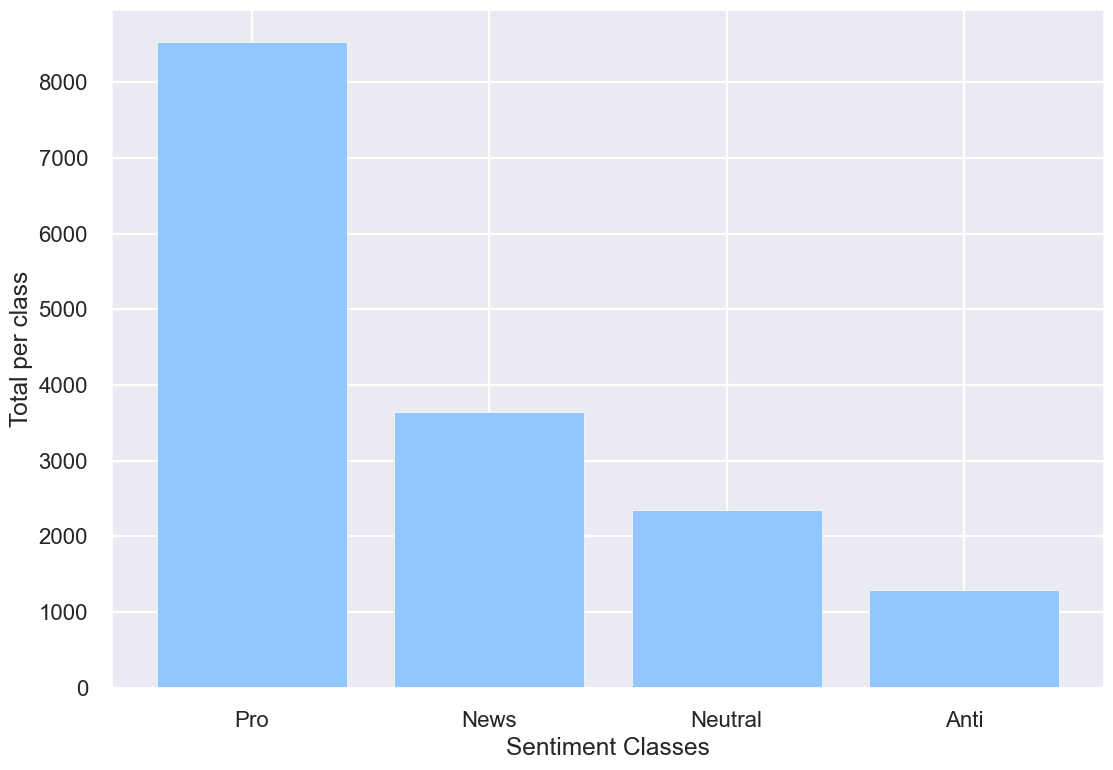

In [76]:
counts = df["sentiment"].value_counts()
plt.bar(range(len(counts)), counts)
plt.xticks([0, 1, 2, 3], ['Pro', 'News', 'Neutral', 'Anti'])


plt.ylabel("Total per class")
plt.xlabel("Sentiment Classes")
plt.show()

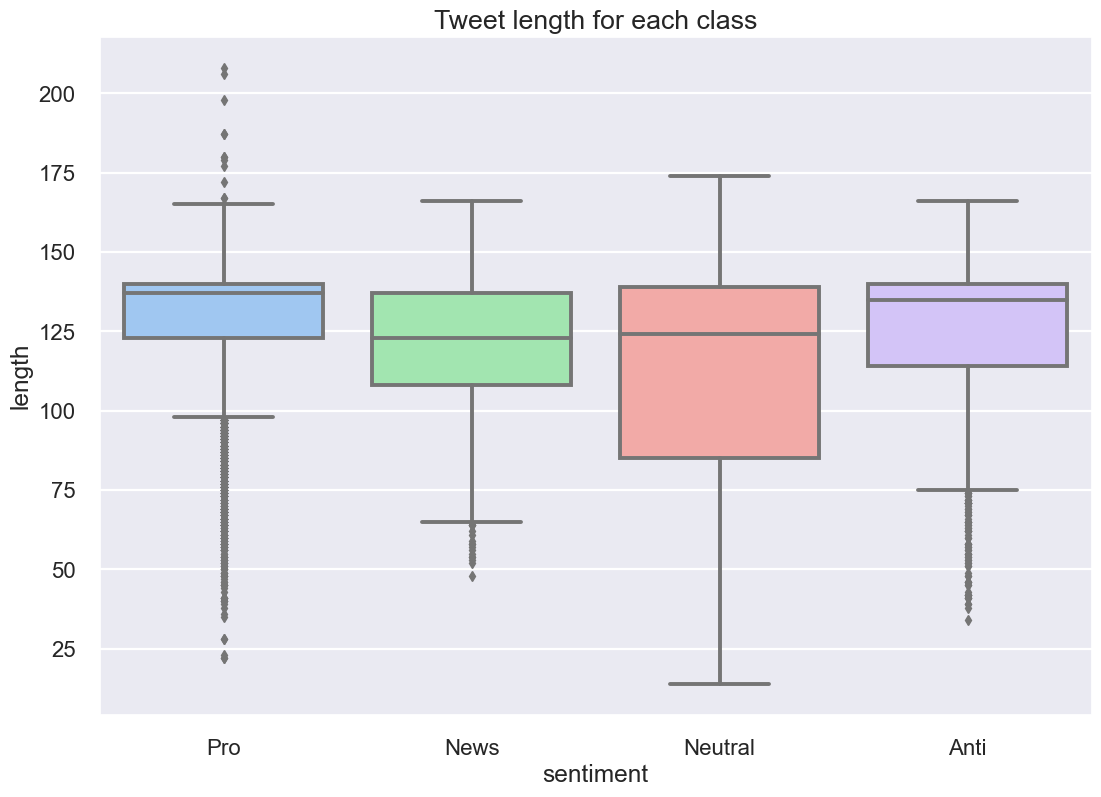

In [77]:
# Plot the distribution of the length tweets for each class using a box plot
sns.boxplot(x=df['sentiment'], y=df['length'], data=df)
plt.title('Tweet length for each class')
plt.show()

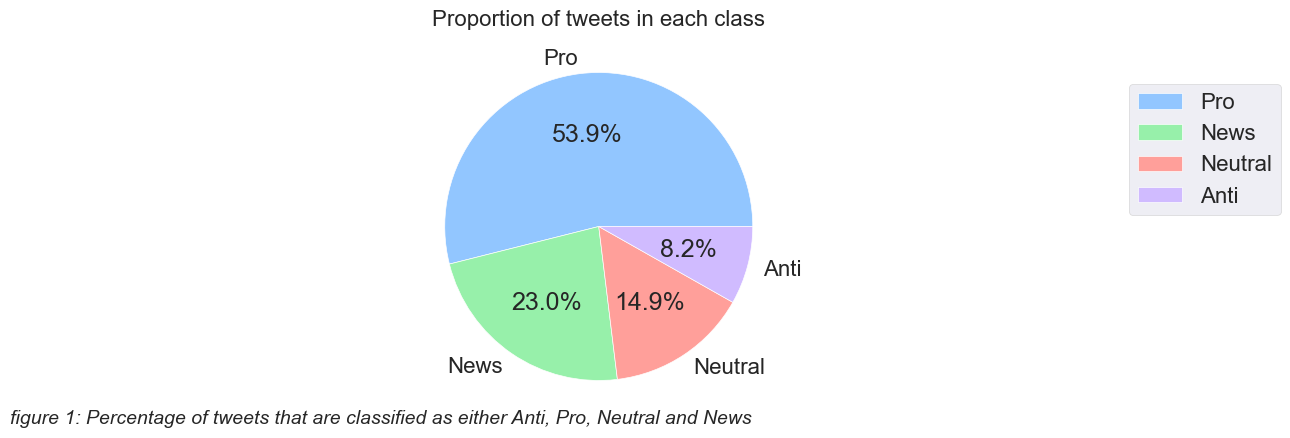

In [78]:
# Plot the proportion of tweets per class
plot1 = plt.figure(figsize=(15,5))
names = ['Pro','News','Neutral','Anti']
perc = df['sentiment'].replace({-1: 'Anti',0:'Neutral',1:'Pro',2:'News'}).value_counts()
perc.name = ''
perc.plot(kind='pie', labels=names, autopct='%1.1f%%')
plt.title('Proportion of tweets in each class',fontsize = 16)
plt.figtext(0.12, 0.1, 'figure 1: Percentage of tweets that are classified as either Anti, Pro, Neutral and News',
            horizontalalignment='left',fontsize = 14,style='italic')
plt.legend(df['sentiment'].replace({-1: 'Anti: Does not believe in man-made climate change',
                                          0:'Neutral: Neither believes nor refutes man-made climate change',
                                          1:'Pro:Believe in man-made climate change',
                                          2:'News: Factual News about climate change'}).value_counts().index,
           bbox_to_anchor=(2.3,0.7), loc="right")

plt.show()

The Pro climate change is the majority class accounting for about 54% of the data set and 46% being shared amongst the remaining classes. To deal with unbalanced data one can apply resampling to the classes, by adjusting the number of observations in the classes .Below is a function to deal with the uneven distribution of class labels. The function will modify the number of observations for the classes we need to resample.

In [79]:
# Create resampling function
def resampling(df, class1, class2):
    """ A function takes in a dataframe, a class to be resampled, and a class 
        thats observations are to be matched with.

        Parameters
        ----------
        df:     Dataframe to be resampled.
        class1: Integer of the class that is to be resampled.
        class2: Integer of the class whose length is used to resample class1.

        Returns
        -------
        df_resampled:  Resampled dataframe.
    """
    
    df_class1= df[df.sentiment==class1]
    df_class2 = df[df.sentiment==class2]
    df_new= df[df.sentiment!=class1]
    resampled = resample(df_class1, replace=True, n_samples=len(df_class2.sentiment), random_state=50)
    df_resampled = pd.concat([resampled, df_new])    
    return df_resampled

In [80]:
# Create a resampled dataset from our clean dataset
df_resample = resampling(df_train, -1, 2)

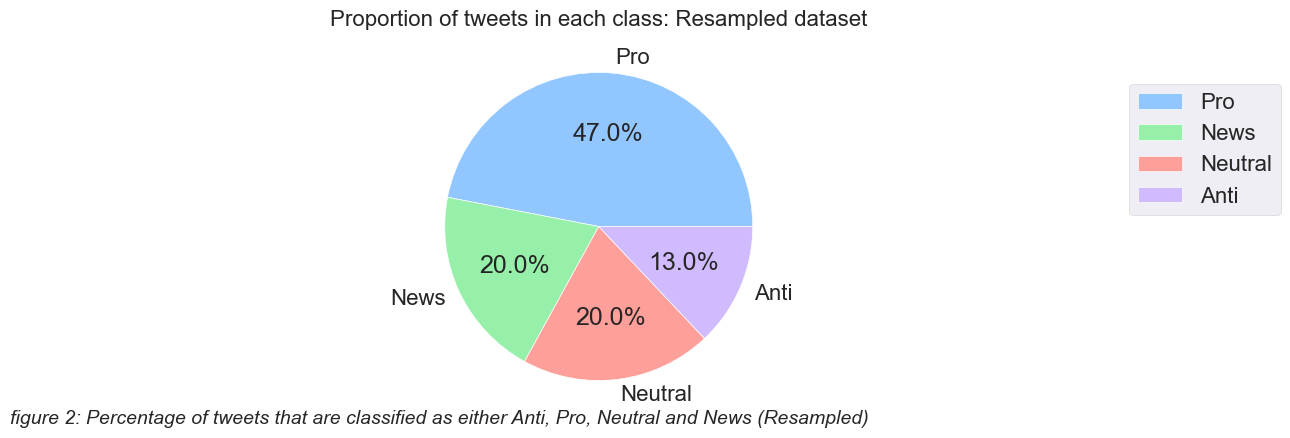

In [81]:
plot2 = plt.figure(figsize=(15,5))
names = ['Pro','News','Neutral','Anti']
perc = df_resample['sentiment'].replace({-1: 'Anti',0:'Neutral',1:'Pro',2:'News'}).value_counts()
perc.name = ''
perc.plot(kind='pie', labels=names, autopct='%1.1f%%')
plt.title('Proportion of tweets in each class: Resampled dataset',fontsize = 16)
plt.figtext(0.12, 0.1, 'figure 2: Percentage of tweets that are classified as either Anti, Pro, Neutral and News (Resampled)',
            horizontalalignment='left',fontsize = 14,style='italic')
plt.legend(df['sentiment'].replace({-1: 'Anti: Does not believe in man-made climate change',
                                          0:'Neutral: Neither believes nor refutes man-made climate change',
                                          1:'Pro:Believe in man-made climate change',
                                          2:'News: Factual News about climate change'}).value_counts().index,
           bbox_to_anchor=(2.3,0.7), loc="right")

plt.show()

## Generate Word cloud
We will look at the most common words found in the tweets for each class.

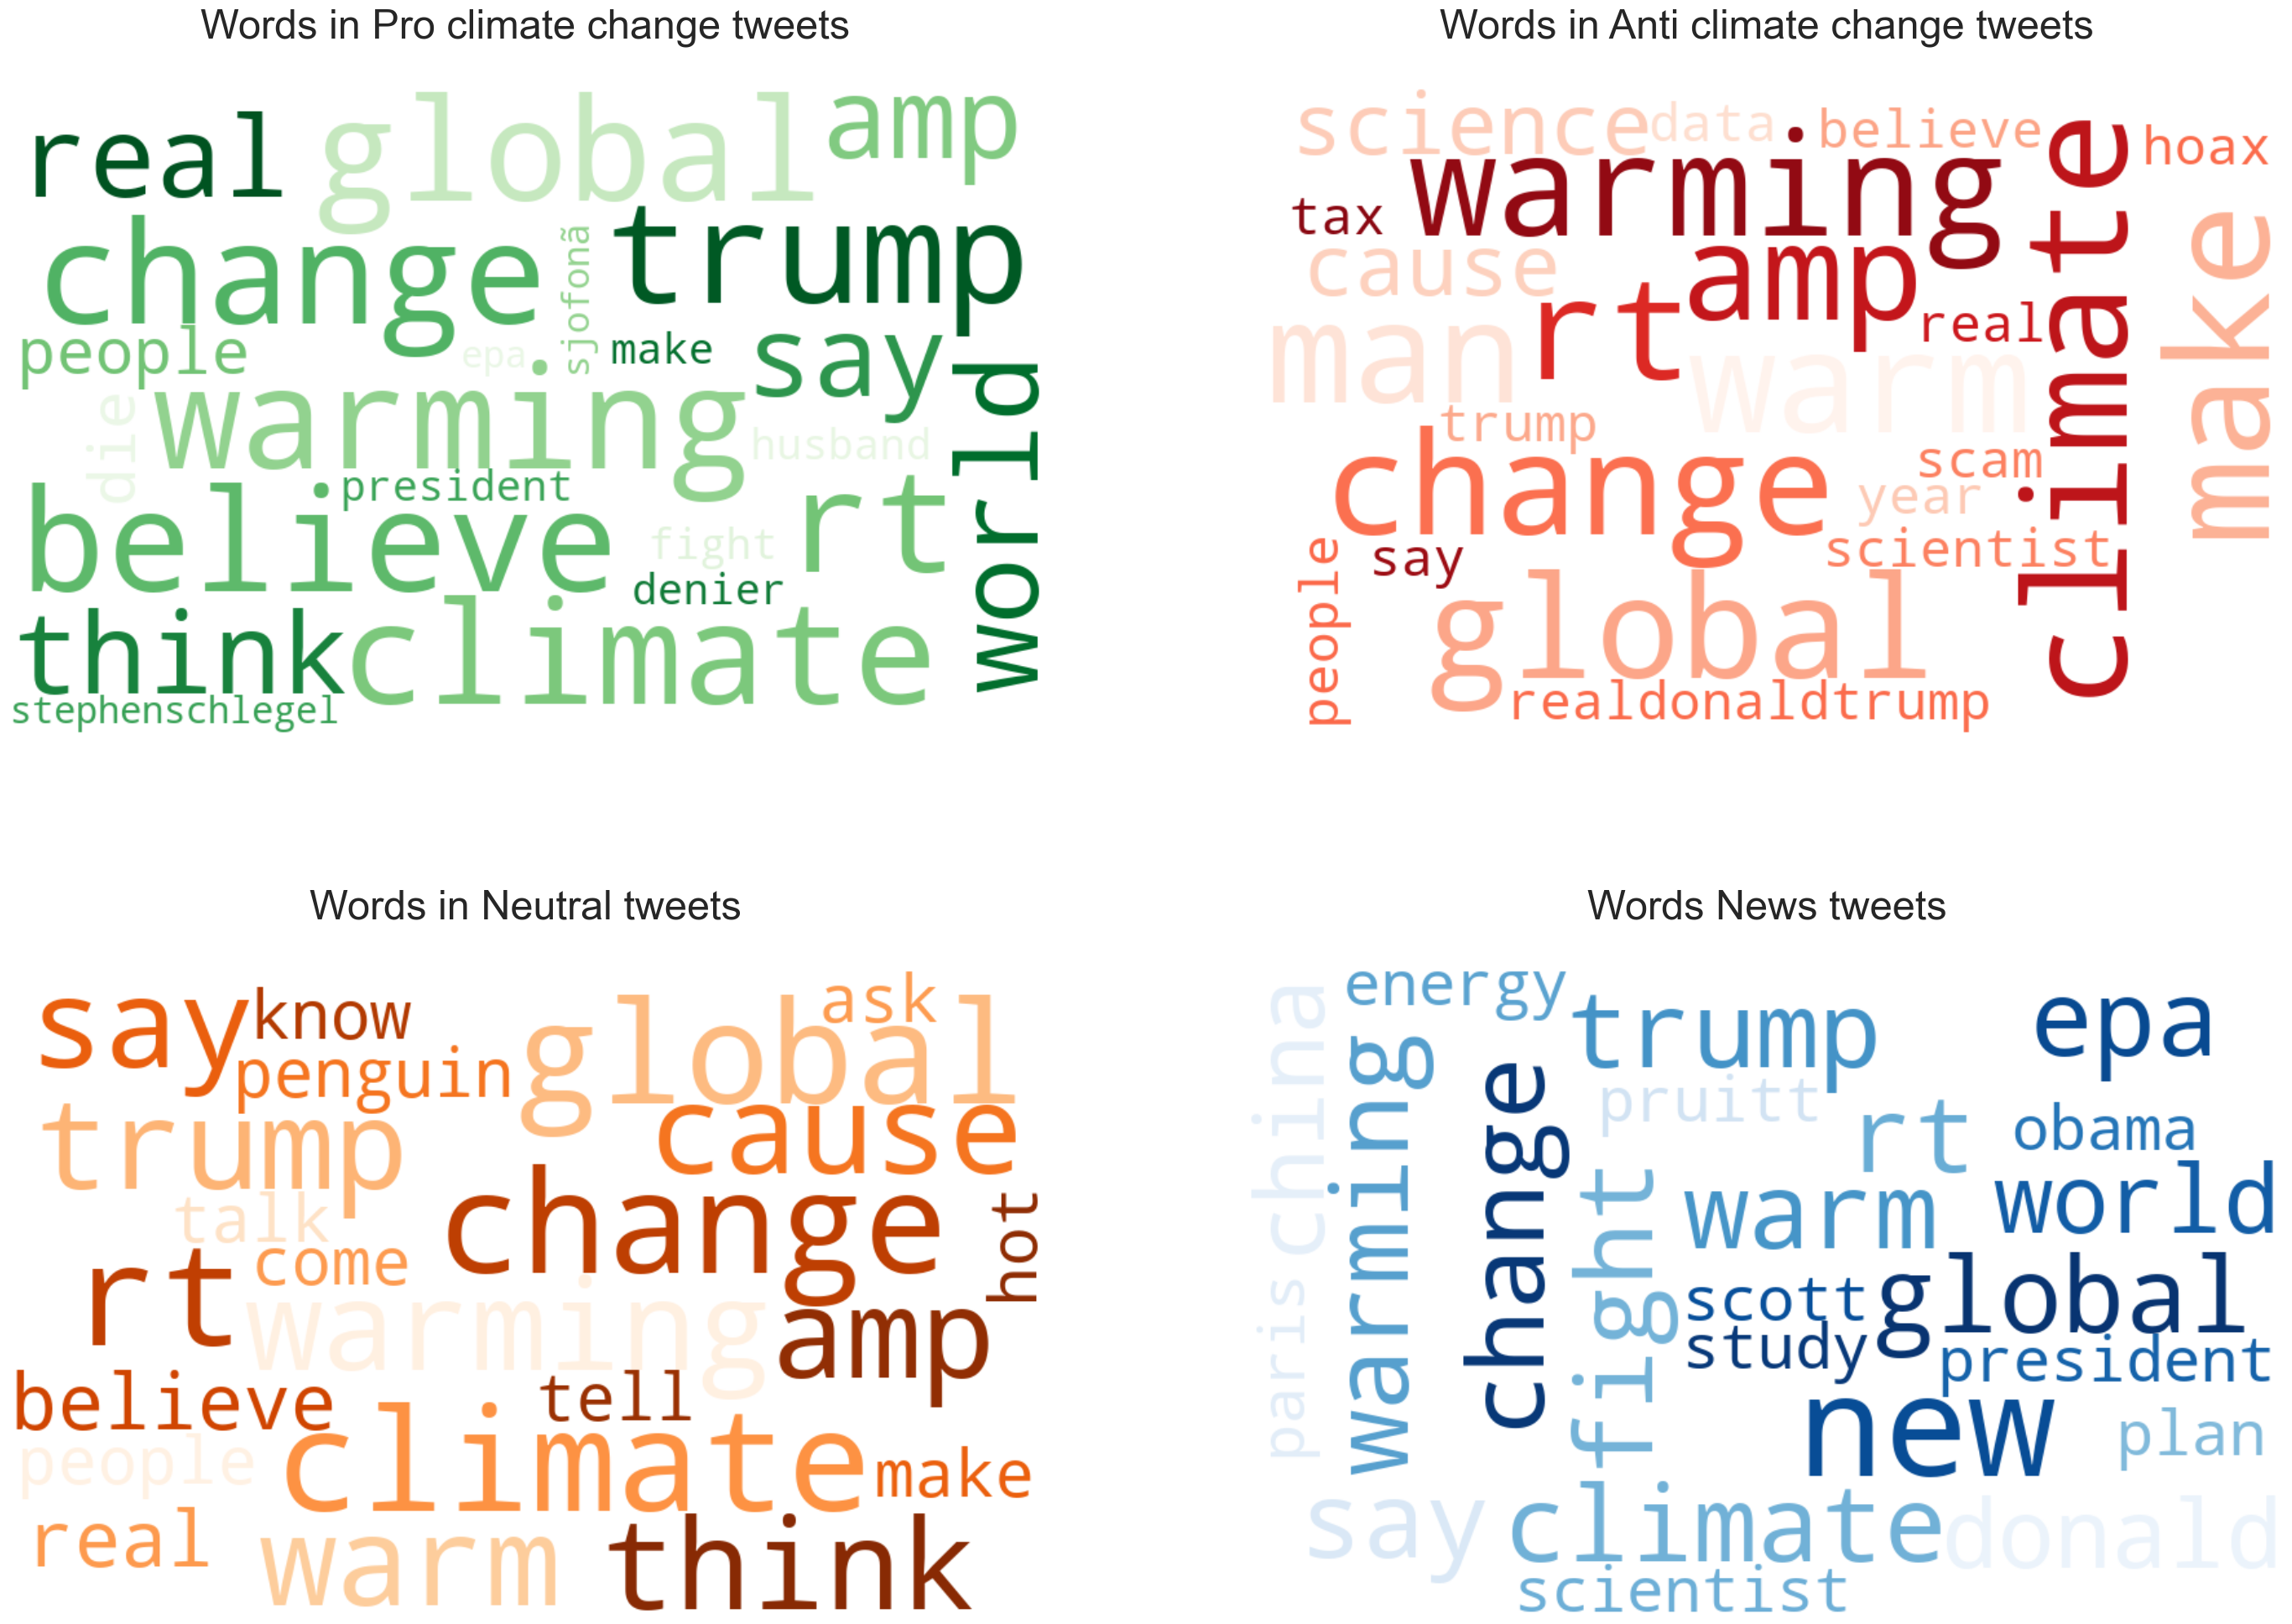

In [82]:
# Plot pro and anti wordclouds next to one another for comparisson
f, axarr = plt.subplots(2,2, figsize=(35,25))
axarr[0,0].imshow(pro_wordcloud, interpolation="bilinear")
axarr[0,1].imshow(anti_wordcloud, interpolation="bilinear")
axarr[1,0].imshow(neutral_wordcloud, interpolation="bilinear")
axarr[1,1].imshow(news_wordcloud, interpolation="bilinear")

# Remove the ticks on the x and y axes
for ax in f.axes:
    plt.sca(ax)
    plt.axis('off')

axarr[0,0].set_title('Words in Pro climate change tweets\n', fontsize=35)
axarr[0,1].set_title('Words in Anti climate change tweets\n', fontsize=35)
axarr[1,0].set_title('Words in Neutral tweets\n', fontsize=35)
axarr[1,1].set_title('Words News tweets\n', fontsize=35)
#plt.tight_layout()
plt.show()

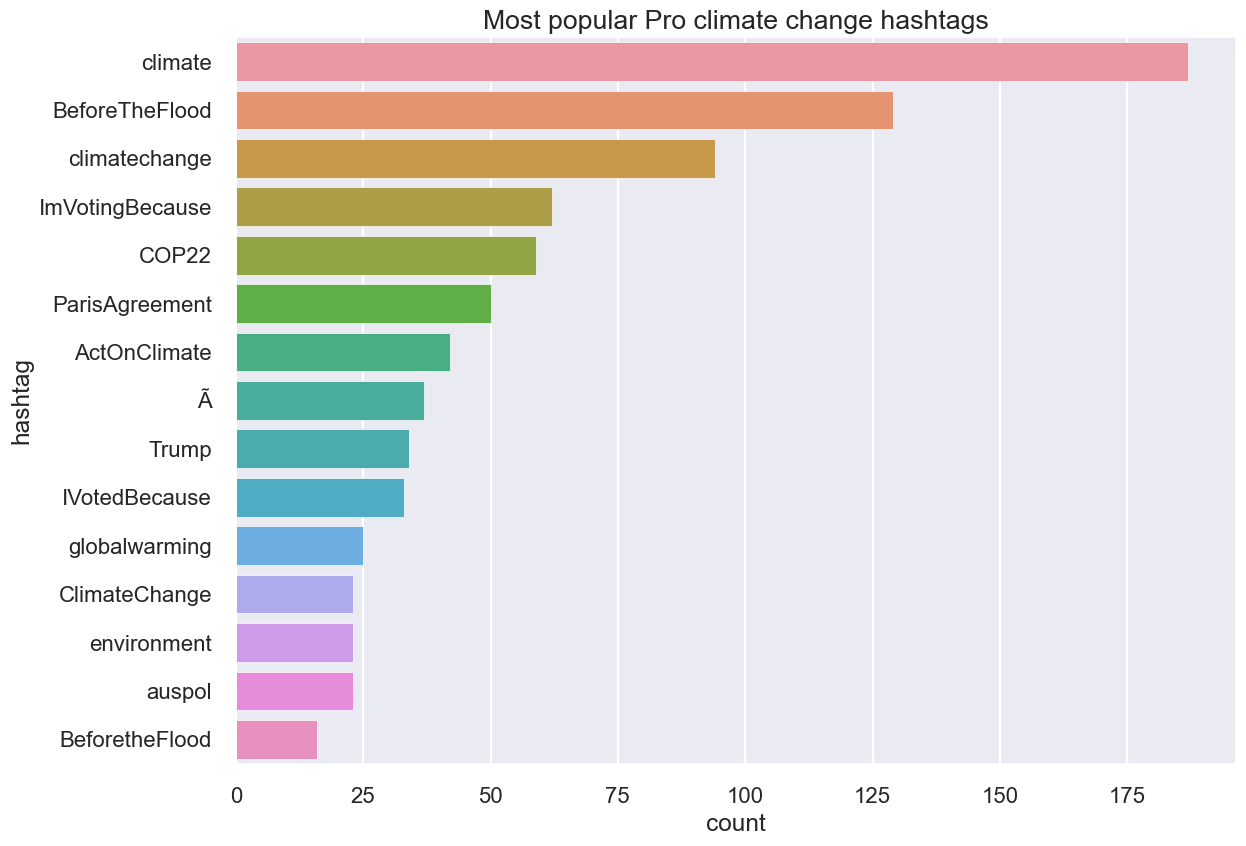

In [83]:
# Plot the frequent hastags for pro and anti climate change classes
sns.barplot(data=pro,y=pro['hashtag'], x=pro['count'])
plt.title('Most popular Pro climate change hashtags')
plt.tight_layout()

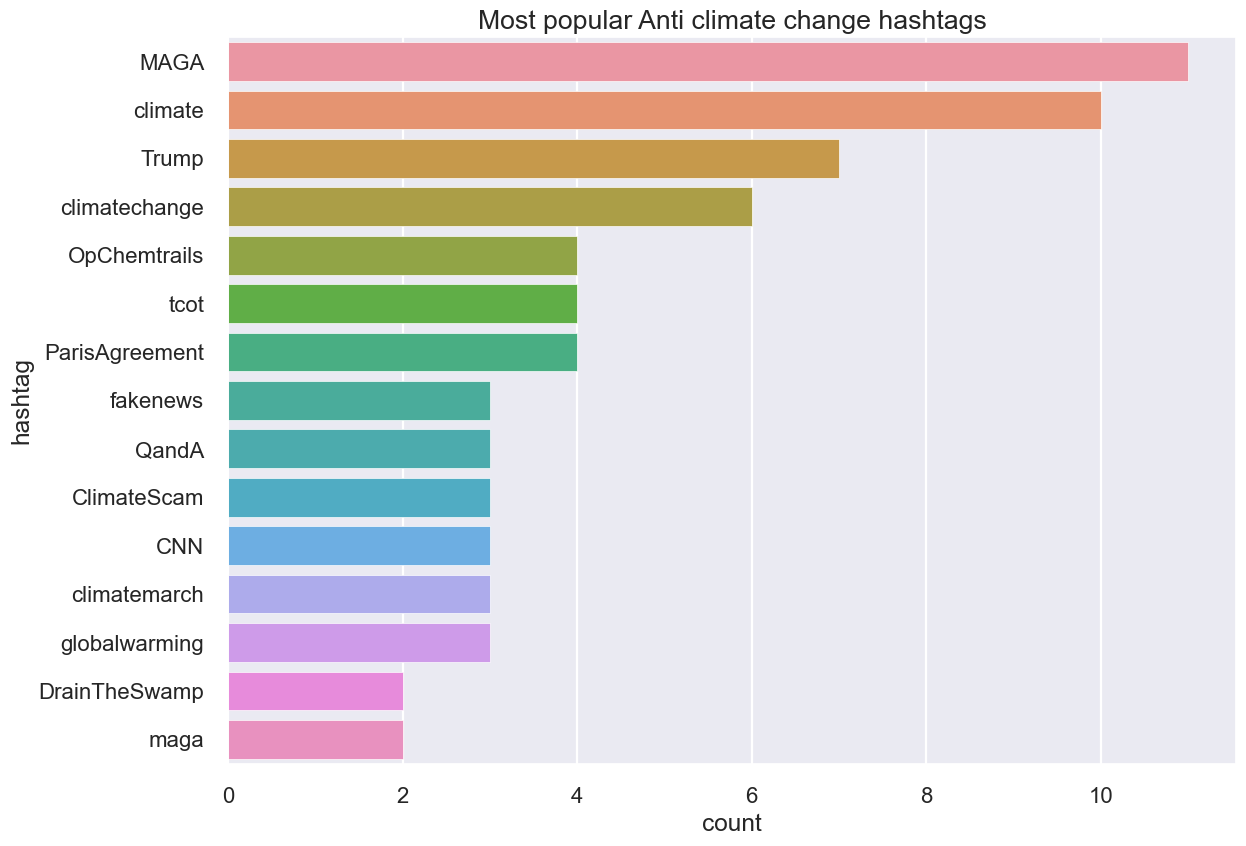

In [84]:
# Plot the frequent hastags for pro and anti climate change classes
sns.barplot(data=anti,y=anti['hashtag'], x=anti['count'])
plt.title('Most popular Anti climate change hashtags')
plt.tight_layout()

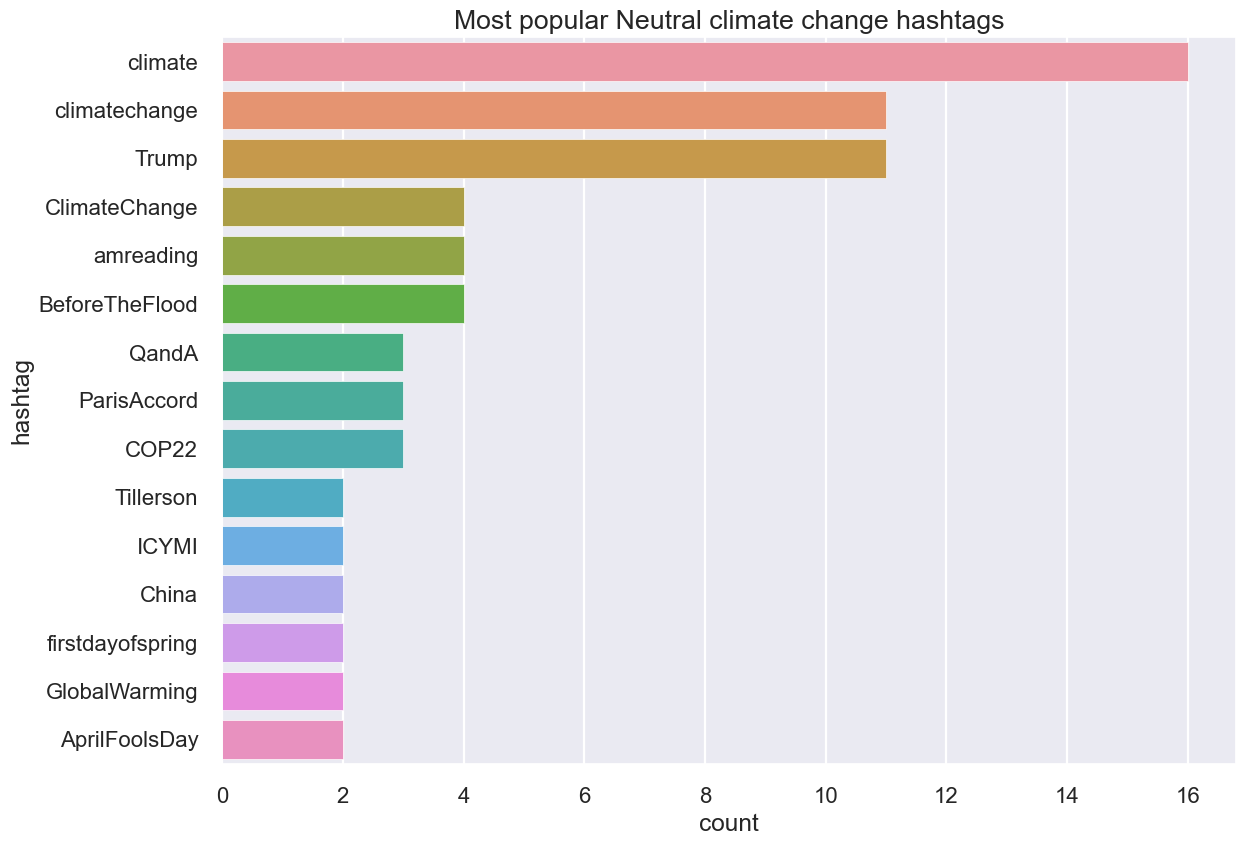

In [85]:
# Plot the frequent hastags for pro and anti climate change classes
sns.barplot(y=neutral['hashtag'], x=neutral['count'])
plt.title('Most popular Neutral climate change hashtags')
plt.tight_layout()

## Data Splitting

In [86]:
# Split the dataset into train & validation for model training

# Seperate features and tagret variables
X = df_resample['message']
y = df_resample['sentiment']

# Split the train data to create validation dataset
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

In [87]:
# Random Forest Classifier
rf = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', RandomForestClassifier(max_depth=5, 
                                              n_estimators=100))])

# Naïve Bayes:
nb = Pipeline([('tfidf', TfidfVectorizer()),
               ('clf', MultinomialNB())])


# Logistic Regression
lr = Pipeline([('tfidf',TfidfVectorizer()),
               ('clf',LogisticRegression(C=1, 
                                         class_weight='balanced', 
                                         max_iter=1000))])
# Linear SVC:
lsvc = Pipeline([('tfidf', TfidfVectorizer()),
                 ('clf', LinearSVC(class_weight='balanced'))])

## Model Training

In [88]:
# Random forest 
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)

# Niave bayes
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_valid)

# Linear regression
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_valid)

# Linear SVC
lsvc.fit(X_train, y_train)
y_pred_lsvc = lsvc.predict(X_valid)

## Random Forest

C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\user\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          -1       0.00      0.00      0.00       725
           0       0.00      0.00      0.00       450
           1       0.48      1.00      0.65      1736
           2       0.00      0.00      0.00       722

    accuracy                           0.48      3633
   macro avg       0.12      0.25      0.16      3633
weighted avg       0.23      0.48      0.31      3633



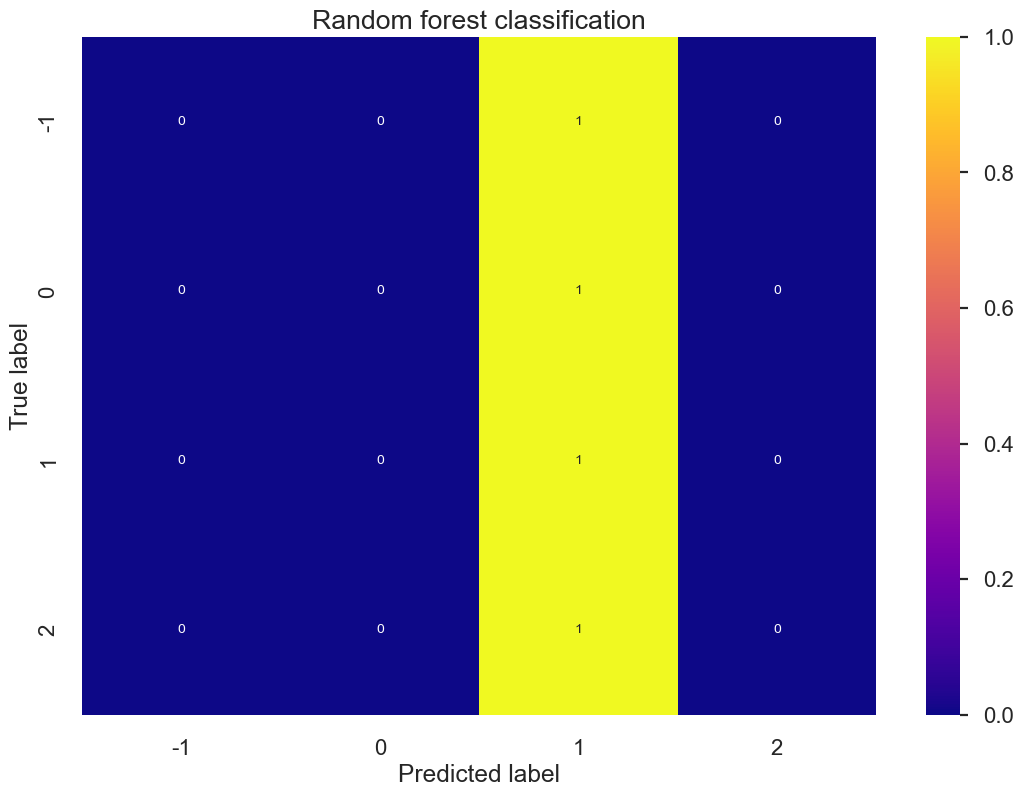

In [89]:
# Generate a classification Report for the random forest model
print(metrics.classification_report(y_valid, y_pred_rf))

# Generate a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_rf)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Display the confusion matrix as a heatmap
sns.heatmap(cm_norm, 
            cmap="plasma", 
            xticklabels=rf.classes_, 
            yticklabels=rf.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':10})

# Adding headings and lables
plt.title('Random forest classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Naive Bayes

              precision    recall  f1-score   support

          -1       0.96      0.58      0.72       725
           0       1.00      0.07      0.13       450
           1       0.61      0.99      0.75      1736
           2       0.89      0.41      0.56       722

    accuracy                           0.68      3633
   macro avg       0.87      0.51      0.54      3633
weighted avg       0.78      0.68      0.63      3633



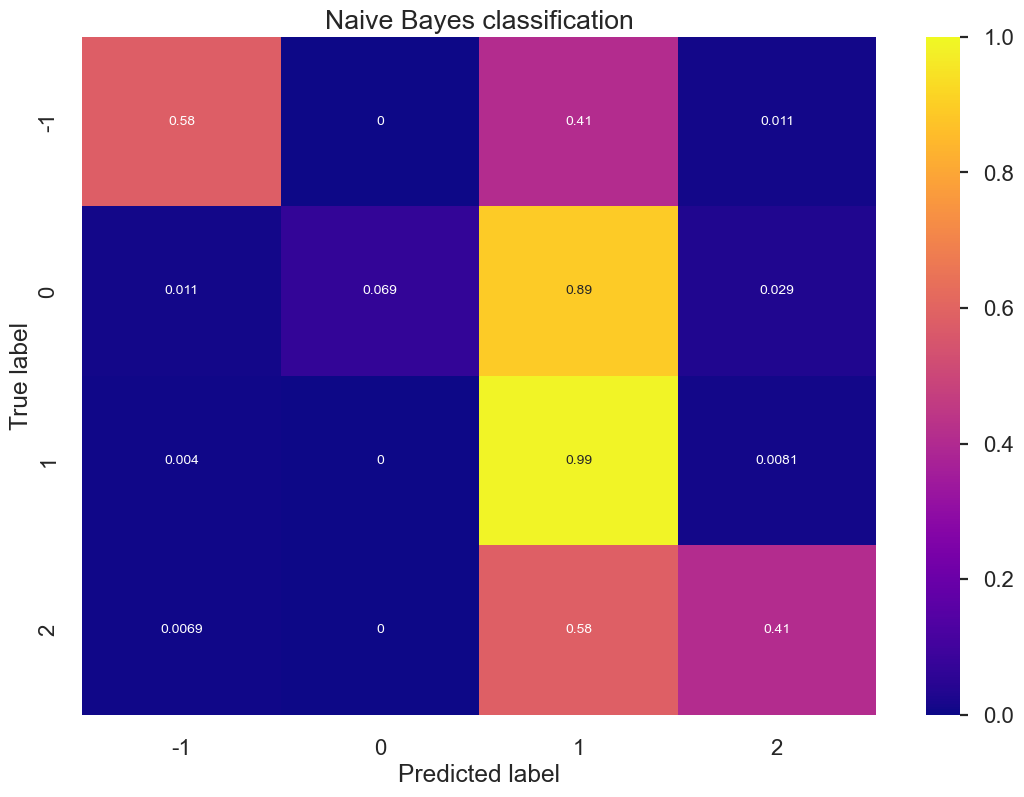

In [90]:
# Generate a classification Report for the Naive Bayes model
print(metrics.classification_report(y_valid, y_pred_nb))

# Generate a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_nb)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Display the confusion matrix as a heatmap
sns.heatmap(cm_norm, 
            cmap="plasma", 
            xticklabels=nb.classes_, 
            yticklabels=nb.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':10})

# Adding headings and lables
plt.title('Naive Bayes classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Logic Regression

              precision    recall  f1-score   support

          -1       0.81      0.89      0.85       725
           0       0.48      0.56      0.52       450
           1       0.86      0.70      0.77      1736
           2       0.69      0.87      0.77       722

    accuracy                           0.75      3633
   macro avg       0.71      0.75      0.73      3633
weighted avg       0.77      0.75      0.75      3633



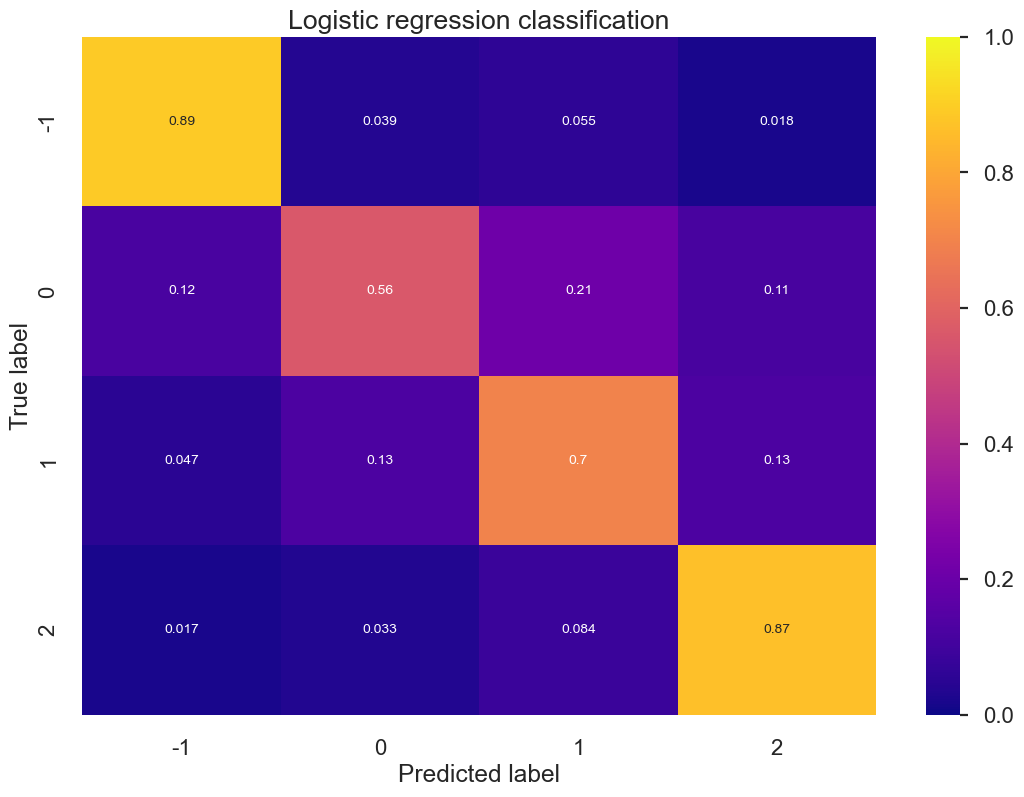

In [91]:
# Generate a classification Report for the model
print(metrics.classification_report(y_valid, y_pred_lr))

cm = confusion_matrix(y_valid, y_pred_lr)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

sns.heatmap(cm_norm, 
            cmap="plasma", 
            xticklabels=lr.classes_, 
            yticklabels=lr.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':10})

# Adding headings and lables
plt.title('Logistic regression classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## Linear SVC

              precision    recall  f1-score   support

          -1       0.87      0.94      0.90       725
           0       0.57      0.49      0.53       450
           1       0.84      0.80      0.82      1736
           2       0.75      0.85      0.80       722

    accuracy                           0.80      3633
   macro avg       0.76      0.77      0.76      3633
weighted avg       0.80      0.80      0.80      3633



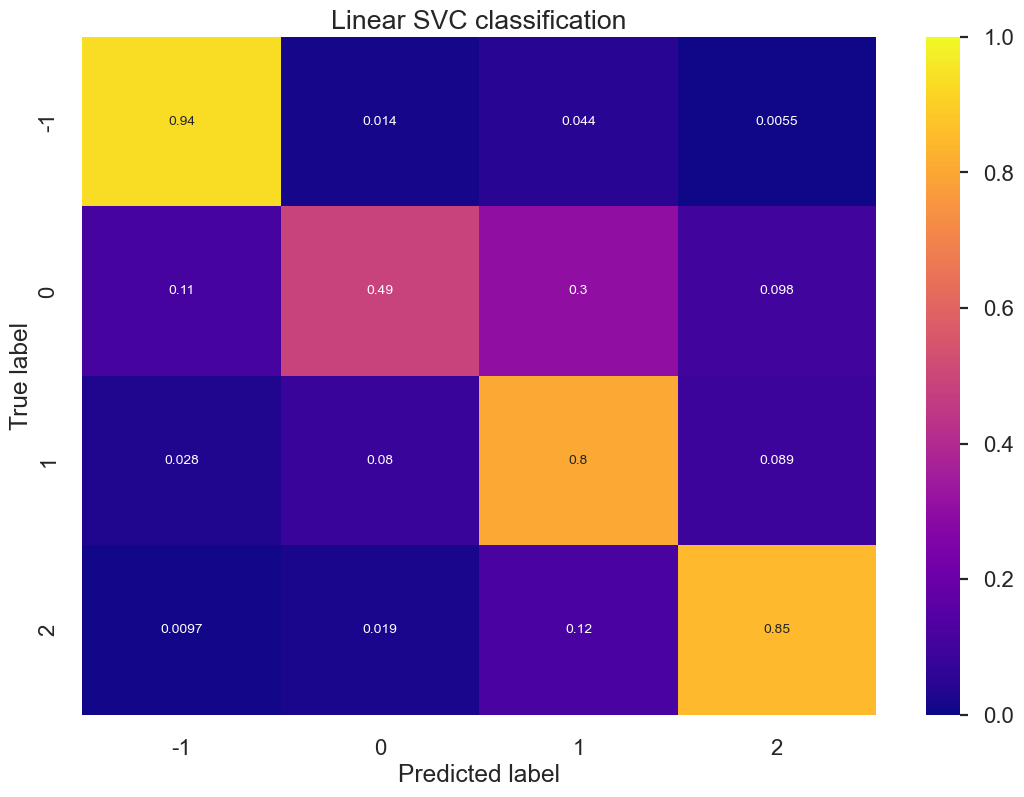

In [92]:
# Generate a classification Report for the linear SVC model
print(metrics.classification_report(y_valid, y_pred_lsvc))

# Generate a normalized confusion matrix
cm = confusion_matrix(y_valid, y_pred_lsvc)
cm_norm = cm / cm.sum(axis=1).reshape(-1,1)

# Display the confusion matrix as a heatmap
sns.heatmap(cm_norm, 
            cmap="plasma", 
            xticklabels=lsvc.classes_, 
            yticklabels=lsvc.classes_, 
            vmin=0., 
            vmax=1., 
            annot=True, 
            annot_kws={'size':10})

# Adding headings and lables
plt.title('Linear SVC classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

 ## Model Selected
The Linear SVC Classification model achieved the highest F1 score of 0.80. 

## End Comet experiment

In [93]:
# Saving each metric to add to a dictionary for logging
f1 = f1_score(y_valid, y_pred_lsvc, average='weighted')
precision = precision_score(y_valid, y_pred_lsvc, average='weighted')
recall = recall_score(y_valid, y_pred_lsvc, average='weighted')

# Create dictionaries for the data we want to log          
metrics = {"f1": f1,
           "recall": recall,
           "precision": precision}

params= {'classifier': 'linear SVC',
         'max_df': 0.8,
         'min_df': 2,
         'ngram_range': '(1,2)',
         'vectorizer': 'Tfidf',
         'scaling': 'no',
         'resampling': 'no',
         'test_train random state': '0'}
  
# Log info on comet
experiment.log_metrics(metrics)
experiment.log_parameters(params)

# End experiment
experiment.end()

# Display results on comet page
experiment.display()


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kennedyee/twitter/4f388718b5e1482790eadad86dd78f57
COMET INFO:   Metrics:
COMET INFO:     f1        : 0.7970914375989842
COMET INFO:     precision : 0.7971306897263896
COMET INFO:     recall    : 0.8001651527663088
COMET INFO:   Parameters:
COMET INFO:     alpha                         : 1.0
COMET INFO:     bootstrap                     : True
COMET INFO:     ccp_alpha                     : 0.0
COMET INFO:     class_prior                   : 1
COMET INFO:     class_weight                  : 1
COMET INFO:     classifier                    : linear SVC
COMET INFO:     clf_C                         : 1
COMET INFO:     clf__C       

COMET INFO:     tfidf__stop_words             : 1
COMET INFO:     tfidf__strip_accents          : 1
COMET INFO:     tfidf__sublinear_tf           : False
COMET INFO:     tfidf__token_pattern          : (?u)\b\w\w+\b
COMET INFO:     tfidf__tokenizer              : 1
COMET INFO:     tfidf__use_idf                : True
COMET INFO:     tfidf__vocabulary             : 1
COMET INFO:     tfidf_analyzer                : word
COMET INFO:     tfidf_binary                  : False
COMET INFO:     tfidf_decode_error            : strict
COMET INFO:     tfidf_dtype                   : <class 'numpy.float64'>
COMET INFO:     tfidf_encoding                : utf-8
COMET INFO:     tfidf_input                   : content
COMET INFO:     tfidf_lowercase               : True
COMET INFO:     tfidf_max_df                  : 1.0
COMET INFO:     tfidf_max_features            : 1
COMET INFO:     tfidf_min_df                  : 1
COMET INFO:     tfidf_ngram_range             : (1, 1)
COMET INFO:     tfidf_norm 

In [94]:
test = pd.read_csv('test.csv')
y_test = lsvc.predict(test['message'])
output = pd.DataFrame({'tweetid': test.tweetid,
                       'sentiment': y_test})
output.to_csv('submission.csv', index=False)
output

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0
...,...,...
10541,895714,1
10542,875167,1
10543,78329,2
10544,867455,0
